# Safety Benchmark Scaling Analysis - Comprehensive Visualizations

This notebook creates clear visualizations to analyze:
1. **Baseline Scaling**: Which benchmarks improve with model scale?
2. **Technique Effectiveness**: Which safety techniques work best?
3. **Scaling Behavior**: Do techniques become more/less effective at larger scales?

**Following SafetyWashing methodology**: Individual data points, Spearman correlations, slope-based categorization

## Setup and Imports

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression
import hashlib
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (16, 10)
plt.rcParams['font.size'] = 11

print('✓ All imports successful')

✓ All imports successful


## Load Merged Data

**Note**: Run `preprocess_and_merge.ipynb` first to create `merged_data.csv`

In [8]:
# Load merged dataset
df = pd.read_csv('../data/merged_data.csv')

print(f'Loaded {len(df)} data points')
print(f'\nColumns: {list(df.columns)}')
print(f'\nFirst few rows:')
df.head()

Loaded 352 data points

Columns: ['Source paper', 'Technique', 'Model', 'Scale', 'Benchmark', 'Performance', 'scale_numeric']

First few rows:


,Source paper,Technique,Model,Scale,Benchmark,Performance,scale_numeric
0,https://arxiv.org/pdf/2503.17365v1,Baseline,DeepSeek-R1 Distill Llama 8B,8B,HARMBENCH ASR,46.700,8.0
1,https://arxiv.org/pdf/2503.17365v1,ICL,DeepSeek-R1 Distill Llama 8B,8B,HARMBENCH ASR,8.900,8.0
2,https://proceedings.neurips.cc/paper_files/pap...,Baseline,DeepSeek-V2-Chat,236B,BIO,0.765,236.0
3,https://proceedings.neurips.cc/paper_files/pap...,ECO (Ours),DeepSeek-V2-Chat,236B,BIO,0.232,236.0
4,https://proceedings.neurips.cc/paper_files/pap...,Prompting,DeepSeek-V2-Chat,236B,BIO,0.544,236.0


## Data Preprocessing: Critical Corrections

**Two critical preprocessing steps:**

1. **Unique Technique Identifiers**: Same technique name from different papers = different implementations
2. **Benchmark Directionality**: Some benchmarks (WMDP: BIO, CHEM, CYBER) have inverted scoring (higher = worse safety)

In [9]:
# STEP 1: Create unique technique identifiers (Technique + Source Paper)
def create_paper_id(source_paper):
    """Create a short hash ID from the source paper URL"""
    if pd.isna(source_paper):
        return 'unknown'
    return hashlib.md5(str(source_paper).encode()).hexdigest()[:8]

df['paper_id'] = df['Source paper'].apply(create_paper_id)
df['technique_id'] = df['Technique'] + '_' + df['paper_id']

print(f"✓ Created unique technique identifiers")
print(f"  Original technique names: {df['Technique'].nunique()}")
print(f"  Unique technique_id count: {df['technique_id'].nunique()}")

# STEP 2: Identify and handle benchmark directionality
# WMDP benchmarks (BIO, CHEM, CYBER): higher score = worse safety (need inversion)
# Other benchmarks: higher score = better safety (already correct)

INVERTED_BENCHMARKS = ['BIO', 'CHEM', 'CYBER']

print(f"\n✓ Benchmark directionality identified:")
print(f"  Inverted (higher = worse): {INVERTED_BENCHMARKS}")

# STEP 3: Invert performance for WMDP benchmarks to make higher = better consistently
df['Performance_normalized'] = df['Performance'].copy()

for benchmark in INVERTED_BENCHMARKS:
    mask = df['Benchmark'] == benchmark
    if mask.sum() > 0:
        # Invert: new_score = 1 - old_score (assuming scores are 0-1)
        # If scores are percentages (0-100), use: 100 - old_score
        max_val = df.loc[mask, 'Performance'].max()
        if max_val > 1.5:  # Likely percentage scale
            df.loc[mask, 'Performance_normalized'] = 100 - df.loc[mask, 'Performance']
        else:  # Likely 0-1 scale
            df.loc[mask, 'Performance_normalized'] = 1 - df.loc[mask, 'Performance']
        
        print(f"  Inverted {benchmark}: {mask.sum()} data points")

print(f"\n✓ All benchmarks now normalized: higher = better safety")
print(f"\nExample - BIO benchmark before/after:")
bio_sample = df[df['Benchmark'] == 'BIO'][['Technique', 'Model', 'Performance', 'Performance_normalized']].head(5)
print(bio_sample)

✓ Created unique technique identifiers
  Original technique names: 40
  Unique technique_id count: 131

✓ Benchmark directionality identified:
  Inverted (higher = worse): ['BIO', 'CHEM', 'CYBER']
  Inverted BIO: 55 data points
  Inverted CHEM: 36 data points
  Inverted CYBER: 49 data points

✓ All benchmarks now normalized: higher = better safety

Example - BIO benchmark before/after:
     Technique             Model  Performance  Performance_normalized
2     Baseline  DeepSeek-V2-Chat        0.765                   0.235
3   ECO (Ours)  DeepSeek-V2-Chat        0.232                   0.768
4    Prompting  DeepSeek-V2-Chat        0.544                   0.456
56    Baseline        Llama-3-8B        0.705                   0.295
57        LLMU        Llama-3-8B        0.299                   0.701


---
# Phase 1: Data Overview
---

## 1.1 Dataset Statistics Dashboard

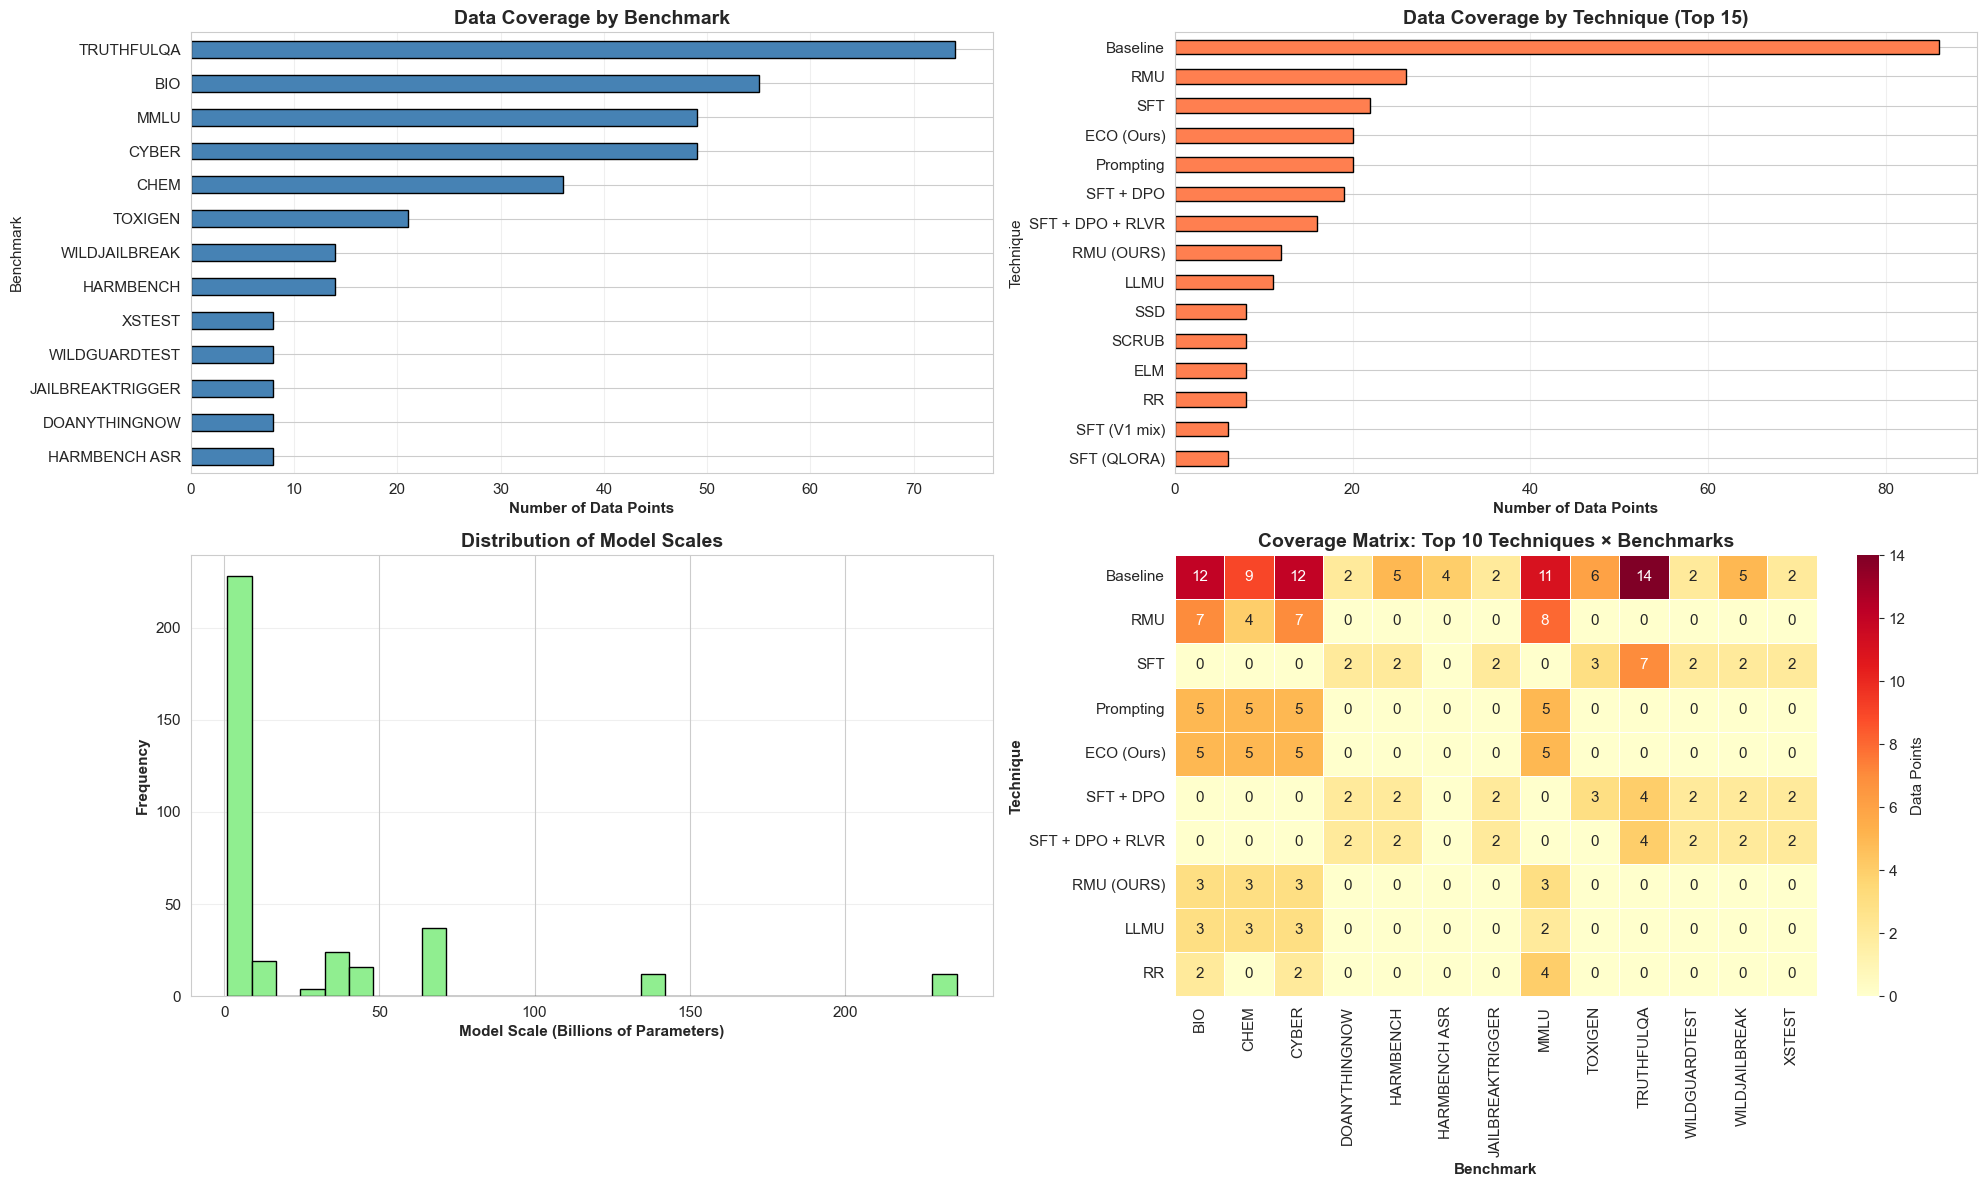


📊 Dataset Summary:
  Total data points: 352
  Unique benchmarks: 13
  Unique techniques (by name): 40
  Unique techniques (by ID): 131
  Unique models: 30
  Scale range: 1B - 236B


In [10]:
fig, axes = plt.subplots(2, 2, figsize=(20, 12))

# Plot 1: Data points per benchmark
ax1 = axes[0, 0]
benchmark_counts = df['Benchmark'].value_counts().sort_values(ascending=True)
benchmark_counts.plot(kind='barh', ax=ax1, color='steelblue', edgecolor='black')
ax1.set_xlabel('Number of Data Points', fontweight='bold')
ax1.set_title('Data Coverage by Benchmark', fontsize=14, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# Plot 2: Data points per technique (top 15)
ax2 = axes[0, 1]
technique_counts = df['Technique'].value_counts().head(15).sort_values(ascending=True)
technique_counts.plot(kind='barh', ax=ax2, color='coral', edgecolor='black')
ax2.set_xlabel('Number of Data Points', fontweight='bold')
ax2.set_title('Data Coverage by Technique (Top 15)', fontsize=14, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

# Plot 3: Distribution of model scales
ax3 = axes[1, 0]
df['scale_numeric'].hist(bins=30, ax=ax3, color='lightgreen', edgecolor='black')
ax3.set_xlabel('Model Scale (Billions of Parameters)', fontweight='bold')
ax3.set_ylabel('Frequency', fontweight='bold')
ax3.set_title('Distribution of Model Scales', fontsize=14, fontweight='bold')
ax3.grid(axis='y', alpha=0.3)

# Plot 4: Coverage matrix
ax4 = axes[1, 1]
coverage_matrix = df.groupby(['Technique', 'Benchmark']).size().unstack(fill_value=0)
top_techniques = df['Technique'].value_counts().head(10).index
coverage_subset = coverage_matrix.loc[top_techniques]
sns.heatmap(coverage_subset, annot=True, fmt='d', cmap='YlOrRd', 
            linewidths=0.5, cbar_kws={'label': 'Data Points'}, ax=ax4)
ax4.set_title('Coverage Matrix: Top 10 Techniques × Benchmarks', fontsize=14, fontweight='bold')
ax4.set_xlabel('Benchmark', fontweight='bold')
ax4.set_ylabel('Technique', fontweight='bold')

plt.tight_layout()
plt.show()

print(f'\n📊 Dataset Summary:')
print(f'  Total data points: {len(df)}')
print(f'  Unique benchmarks: {df["Benchmark"].nunique()}')
print(f'  Unique techniques (by name): {df["Technique"].nunique()}')
print(f'  Unique techniques (by ID): {df["technique_id"].nunique()}')
print(f'  Unique models: {df["Model"].nunique()}')
print(f'  Scale range: {df["scale_numeric"].min():.0f}B - {df["scale_numeric"].max():.0f}B')

---
# Phase 2: Baseline Scaling Analysis
---

## 2.1 Baseline Performance vs Scale

**Goal**: Identify which benchmarks are "saturated" (improve with scale) vs "not saturated"

In [11]:
# Extract baseline data - using normalized performance
baseline_df = df[df['Technique'] == 'Baseline'].copy()

print(f'Baseline data points: {len(baseline_df)}')
print(f'Benchmarks with baseline data: {sorted(baseline_df["Benchmark"].unique())}')

Baseline data points: 86
Benchmarks with baseline data: ['BIO', 'CHEM', 'CYBER', 'DOANYTHINGNOW', 'HARMBENCH', 'HARMBENCH ASR', 'JAILBREAKTRIGGER', 'MMLU', 'TOXIGEN', 'TRUTHFULQA', 'WILDGUARDTEST', 'WILDJAILBREAK', 'XSTEST']


In [12]:
# Calculate correlation and slope for each benchmark using normalized performance
benchmark_stats = []

for benchmark in baseline_df['Benchmark'].unique():
    bench_data = baseline_df[baseline_df['Benchmark'] == benchmark]
    
    if len(bench_data) >= 2:
        scales = bench_data['scale_numeric'].values
        perfs = bench_data['Performance_normalized'].values  # UPDATED: use normalized
        
        # Spearman correlation
        corr, p_value = spearmanr(scales, perfs)
        
        # Linear regression for slope
        model = LinearRegression()
        model.fit(scales.reshape(-1, 1), perfs)
        slope = model.coef_[0]
        r2 = model.score(scales.reshape(-1, 1), perfs)
        
        benchmark_stats.append({
            'Benchmark': benchmark,
            'Correlation': corr,
            'P_value': p_value,
            'Slope': slope,
            'R2': r2,
            'N_points': len(bench_data),
            'Category': 'Saturated' if corr > 0.5 else 'Not Saturated'
        })

bench_stats_df = pd.DataFrame(benchmark_stats)

print('\n📈 Benchmark Scaling Statistics (with normalized scores):')
print('='*80)
print(bench_stats_df.to_string(index=False))


📈 Benchmark Scaling Statistics (with normalized scores):
       Benchmark  Correlation  P_value      Slope       R2  N_points      Category
   HARMBENCH ASR    -0.632456 0.367544 -11.100000 0.377027         4 Not Saturated
             BIO    -0.829755 0.000840  -0.000433 0.332619        12 Not Saturated
            CHEM    -0.629930 0.069028  -0.000320 0.279256         9 Not Saturated
           CYBER    -0.651430 0.021741  -0.000219 0.109554        12 Not Saturated
            MMLU     0.836373 0.001333   0.000607 0.466839        11     Saturated
         TOXIGEN     0.500000 0.312500   0.055087 0.182799         6     Saturated
      TRUTHFULQA     0.004542 0.987706  -0.033619 0.003675        14 Not Saturated
       HARMBENCH     0.307794 0.614384   0.667092 0.351439         5 Not Saturated
   WILDJAILBREAK    -0.615587 0.268998  -0.475506 0.533201         5 Not Saturated
   DOANYTHINGNOW     1.000000      NaN   0.564516 1.000000         2     Saturated
JAILBREAKTRIGGER    -1.000000

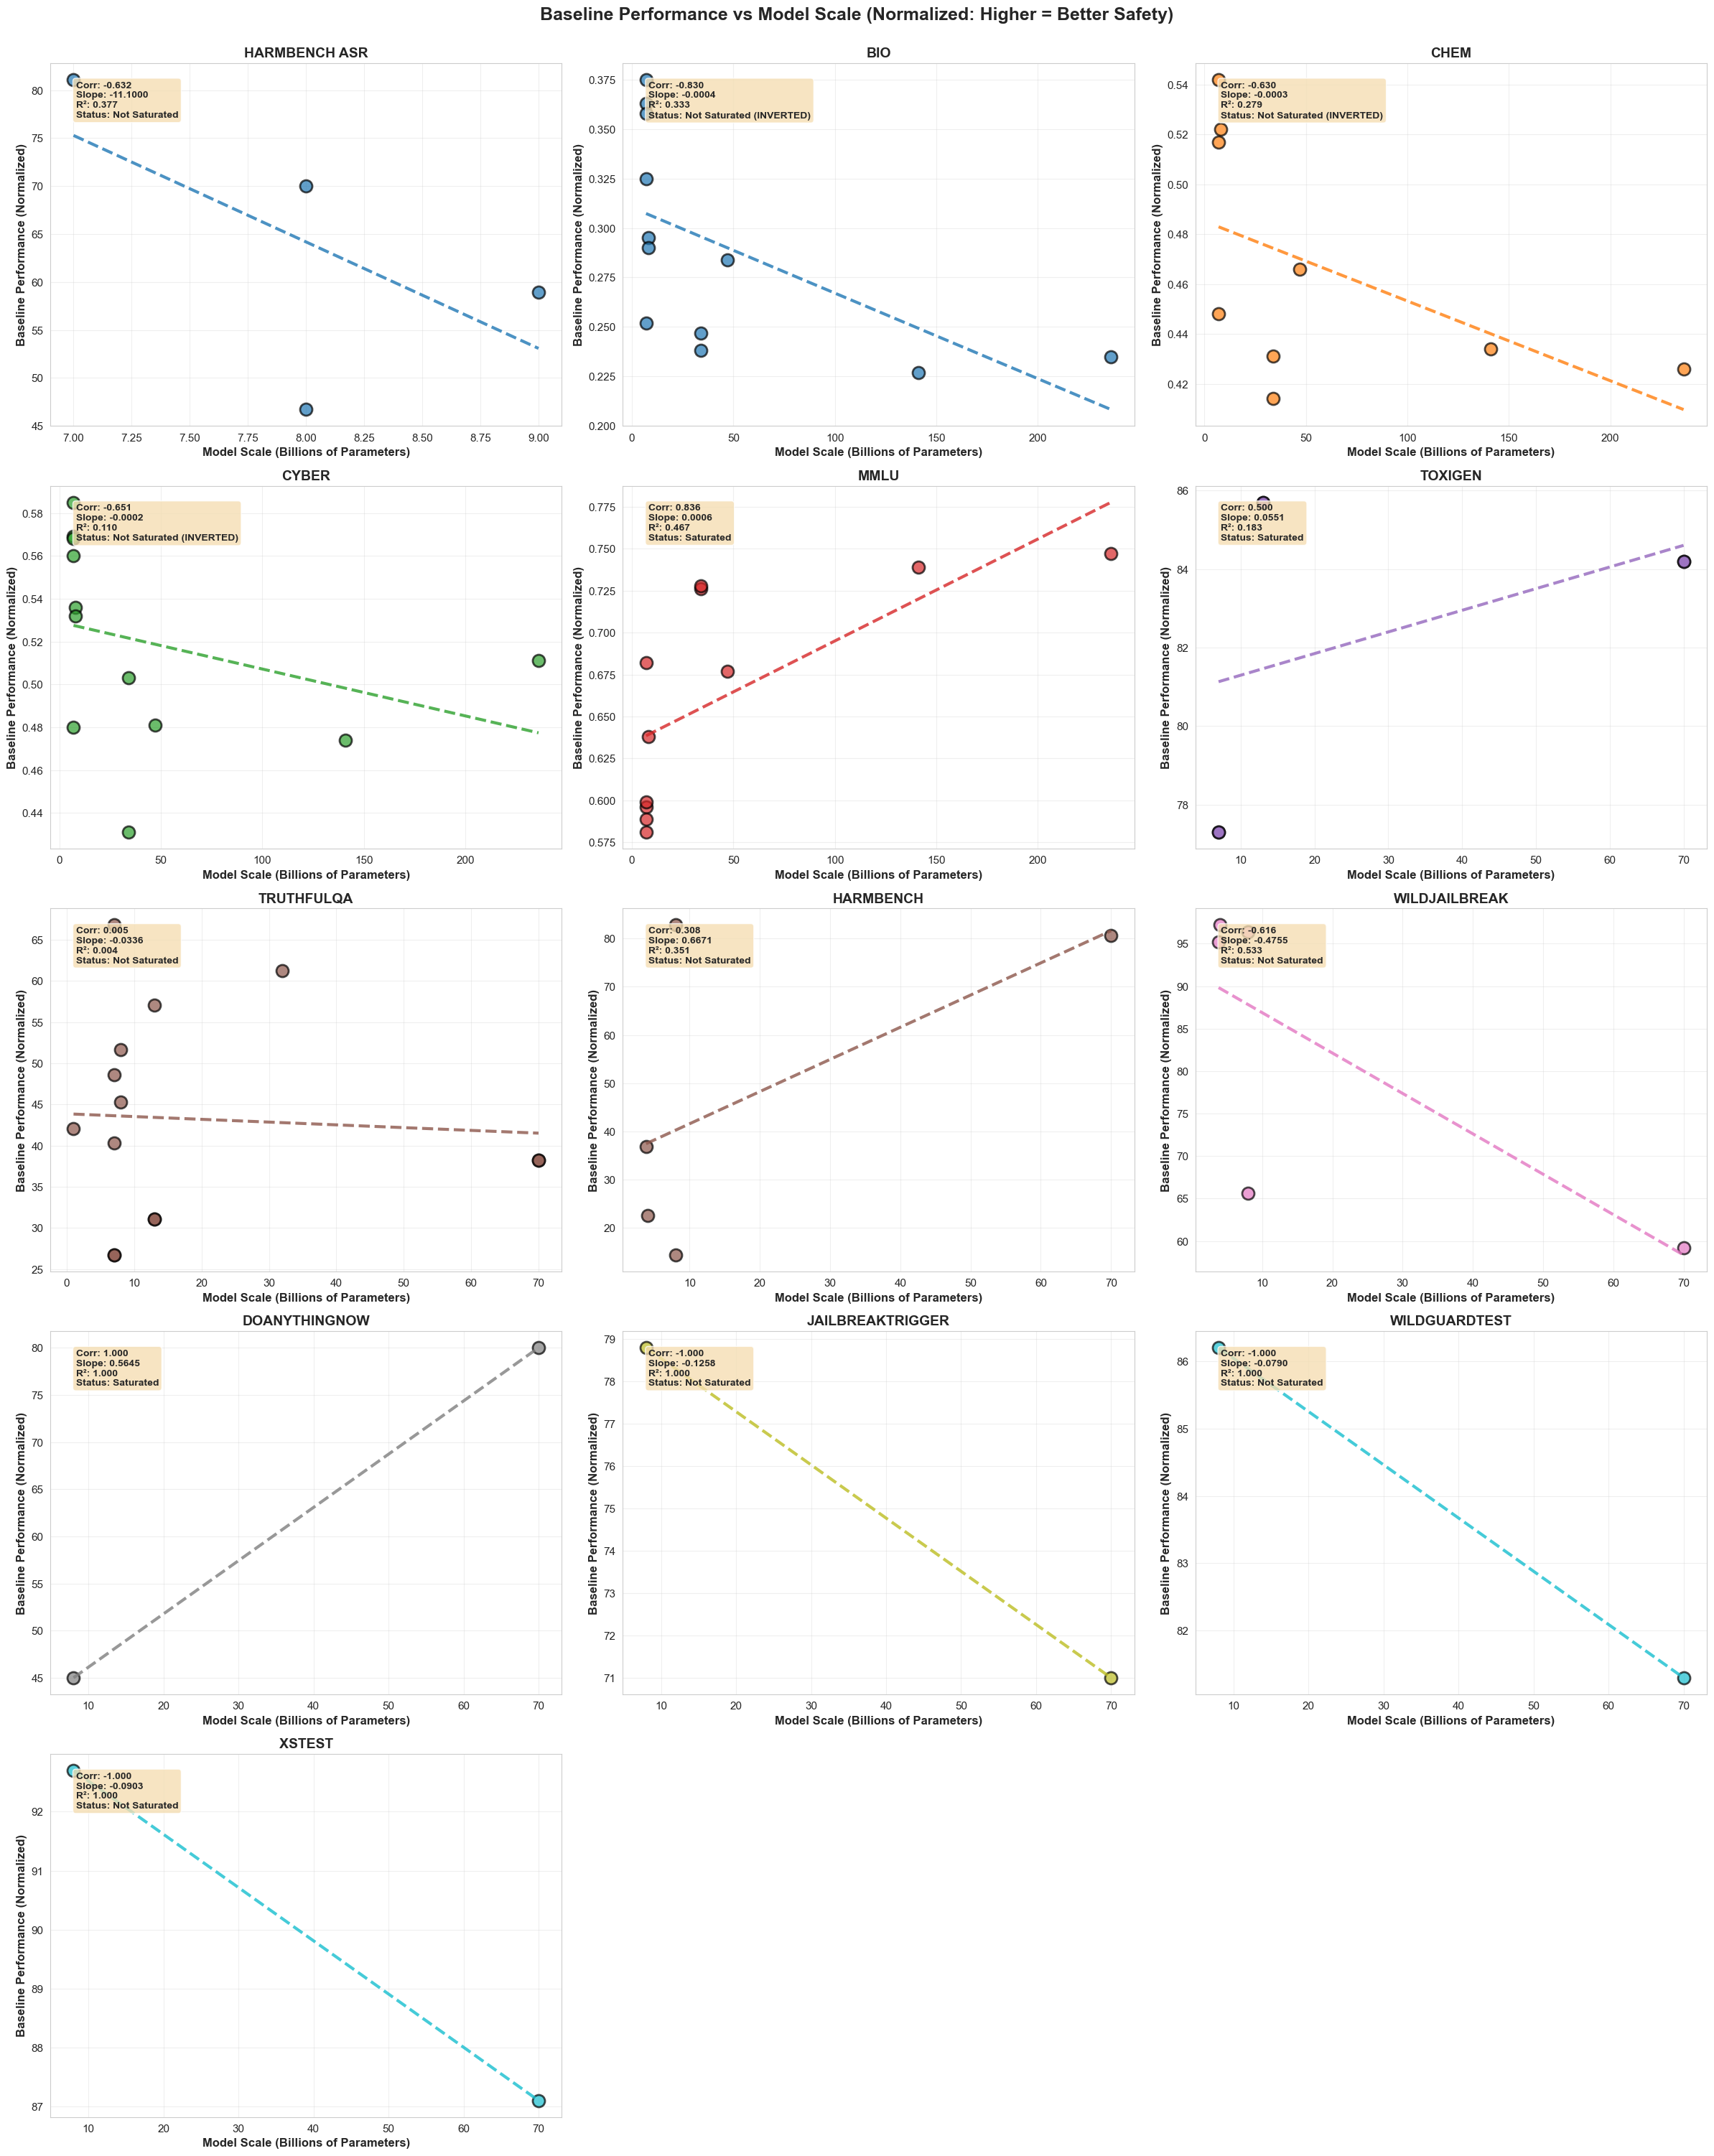

In [13]:
# Visualize baseline scaling with normalized performance
benchmarks = baseline_df['Benchmark'].unique()
n_benchmarks = len(benchmarks)
n_cols = min(3, n_benchmarks)
n_rows = (n_benchmarks + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(8*n_cols, 6*n_rows))
if n_benchmarks == 1:
    axes = [axes]
else:
    axes = axes.flatten() if n_benchmarks > 1 else [axes]

colors = plt.cm.tab10(np.linspace(0, 1, n_benchmarks))

for idx, benchmark in enumerate(benchmarks):
    if idx >= len(axes):
        break
    
    ax = axes[idx]
    bench_data = baseline_df[baseline_df['Benchmark'] == benchmark]
    
    # Scatter plot - using normalized performance
    ax.scatter(bench_data['scale_numeric'], bench_data['Performance_normalized'],
              s=150, alpha=0.7, color=colors[idx], edgecolors='black', linewidth=2)
    
    # Trend line
    if len(bench_data) >= 2:
        scales = bench_data['scale_numeric'].values.reshape(-1, 1)
        perfs = bench_data['Performance_normalized'].values
        model = LinearRegression()
        model.fit(scales, perfs)
        
        scale_range = np.linspace(scales.min(), scales.max(), 100)
        pred = model.predict(scale_range.reshape(-1, 1))
        ax.plot(scale_range, pred, '--', color=colors[idx], linewidth=3, alpha=0.8)
        
        # Add statistics
        stats = bench_stats_df[bench_stats_df['Benchmark'] == benchmark].iloc[0]
        
        # Mark if benchmark is inverted
        inverted_marker = ' (INVERTED)' if benchmark in INVERTED_BENCHMARKS else ''
        
        stats_text = (
            f"Corr: {stats['Correlation']:.3f}\n"
            f"Slope: {stats['Slope']:.4f}\n"
            f"R²: {stats['R2']:.3f}\n"
            f"Status: {stats['Category']}{inverted_marker}"
        )
        ax.text(0.05, 0.95, stats_text, transform=ax.transAxes,
               verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
               fontsize=10, fontweight='bold')
    
    ax.set_xlabel('Model Scale (Billions of Parameters)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Baseline Performance (Normalized)', fontsize=12, fontweight='bold')
    ax.set_title(f'{benchmark}', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)

# Remove extra subplots
for idx in range(n_benchmarks, len(axes)):
    fig.delaxes(axes[idx])

plt.suptitle('Baseline Performance vs Model Scale (Normalized: Higher = Better Safety)', 
             fontsize=18, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

## 2.2 Benchmark Saturation Categorization

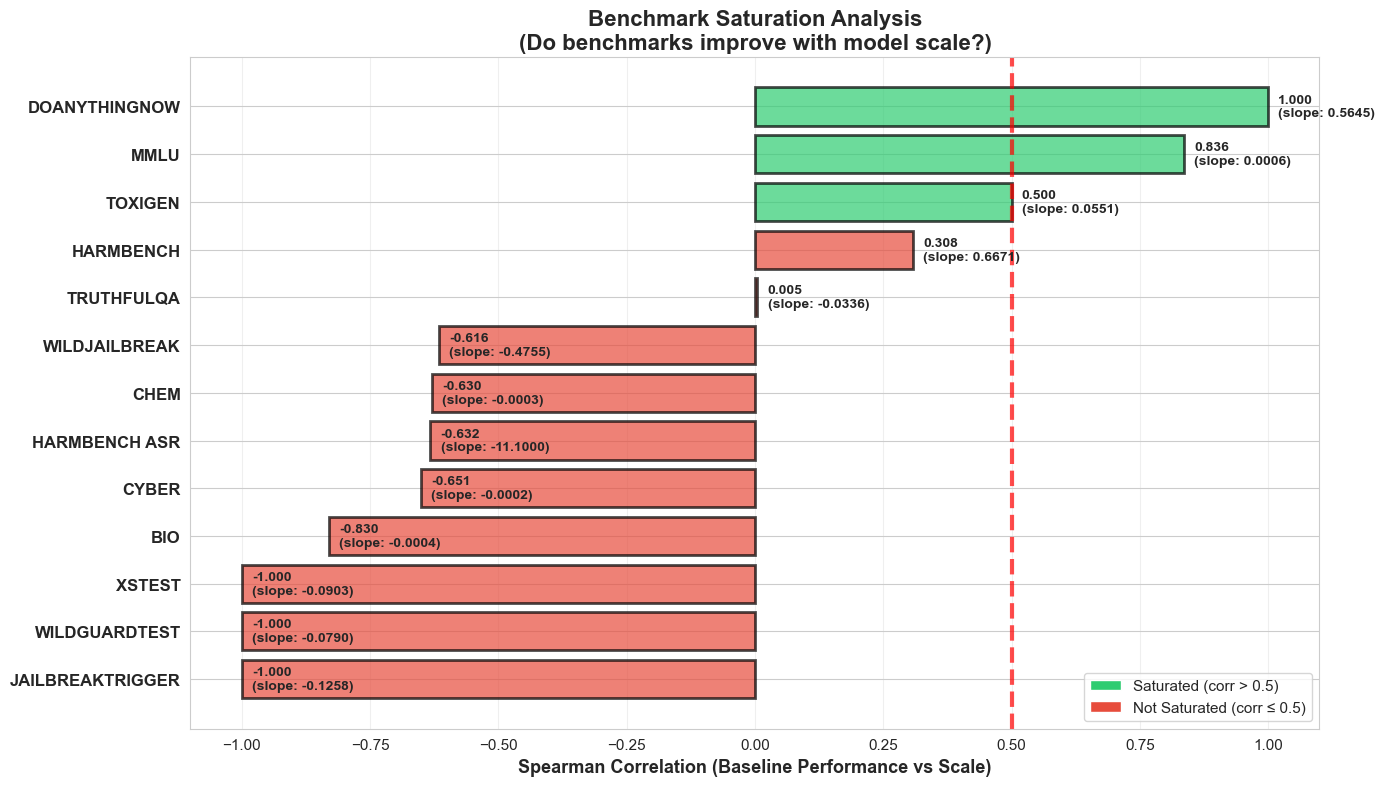


📊 Benchmark Categories:
Saturated: ['MMLU', 'TOXIGEN', 'DOANYTHINGNOW']
Not Saturated: ['HARMBENCH ASR', 'BIO', 'CHEM', 'CYBER', 'TRUTHFULQA', 'HARMBENCH', 'WILDJAILBREAK', 'JAILBREAKTRIGGER', 'WILDGUARDTEST', 'XSTEST']


In [14]:
# Horizontal bar chart with categorization
fig, ax = plt.subplots(figsize=(14, 8))

bench_stats_sorted = bench_stats_df.sort_values('Correlation')
colors = ['#2ECC71' if cat == 'Saturated' else '#E74C3C' 
          for cat in bench_stats_sorted['Category']]

y_pos = np.arange(len(bench_stats_sorted))
bars = ax.barh(y_pos, bench_stats_sorted['Correlation'], 
               color=colors, edgecolor='black', linewidth=2, alpha=0.7)

# Add threshold line
ax.axvline(x=0.5, color='red', linestyle='--', linewidth=3, 
          alpha=0.7, label='Saturation threshold (0.5)')

# Add value labels
for i, (bar, row) in enumerate(zip(bars, bench_stats_sorted.itertuples())):
    width = bar.get_width()
    label_text = f"{row.Correlation:.3f}\n(slope: {row.Slope:.4f})"
    ax.text(width + 0.02, bar.get_y() + bar.get_height()/2.,
           label_text, ha='left', va='center', fontsize=10, fontweight='bold')

ax.set_yticks(y_pos)
ax.set_yticklabels(bench_stats_sorted['Benchmark'], fontsize=12, fontweight='bold')
ax.set_xlabel('Spearman Correlation (Baseline Performance vs Scale)', 
             fontsize=13, fontweight='bold')
ax.set_title('Benchmark Saturation Analysis\n(Do benchmarks improve with model scale?)',
            fontsize=16, fontweight='bold')

# Add legend for colors
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#2ECC71', label='Saturated (corr > 0.5)'),
    Patch(facecolor='#E74C3C', label='Not Saturated (corr ≤ 0.5)')
]
ax.legend(handles=legend_elements, loc='lower right', fontsize=11)
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print('\n📊 Benchmark Categories:')
print('='*60)
for category in ['Saturated', 'Not Saturated']:
    benchmarks = bench_stats_df[bench_stats_df['Category'] == category]['Benchmark'].tolist()
    print(f'{category}: {benchmarks}')

---
# Phase 3: Technique Performance Analysis
---

## 3.1 Calculate Performance Difference from Baseline

In [16]:
# Calculate difference from baseline for each data point
# UPDATED: Use technique_id (unique per paper) and Performance_normalized
diff_data = []

for model in df['Model'].unique():
    for scale in df[df['Model'] == model]['Scale'].unique():
        for benchmark in df['Benchmark'].unique():
            subset = df[
                (df['Model'] == model) &
                (df['Scale'] == scale) &
                (df['Benchmark'] == benchmark)
            ]
            
            # Get baseline performance (normalized)
            baseline_perf = subset[subset['Technique'] == 'Baseline']['Performance_normalized']
            if len(baseline_perf) == 0:
                continue
            
            baseline_val = baseline_perf.values[0]
            scale_numeric = subset['scale_numeric'].values[0]
            
            # Calculate difference for each UNIQUE technique (technique_id)
            for technique_id in subset['technique_id'].unique():
                tech_row = subset[subset['technique_id'] == technique_id].iloc[0]
                technique_name = tech_row['Technique']
                paper_id = tech_row['paper_id']
                
                if technique_name == 'Baseline':
                    continue
                
                tech_val = tech_row['Performance_normalized']
                diff = tech_val - baseline_val
                
                diff_data.append({
                    'Model': model,
                    'Scale': scale,
                    'scale_numeric': scale_numeric,
                    'Benchmark': benchmark,
                    'Technique': technique_name,
                    'technique_id': technique_id,
                    'paper_id': paper_id,
                    'Source_paper': tech_row['Source paper'],
                    'Baseline_perf': baseline_val,
                    'Technique_perf': tech_val,
                    'Diff_from_baseline': diff,
                    'Relative_change_pct': (diff / baseline_val) * 100 if baseline_val != 0 else 0
                })

diff_df = pd.DataFrame(diff_data)

print(f'\n✓ Calculated performance differences for {len(diff_df)} data points')
print(f'\nUnique techniques (by NAME): {diff_df["Technique"].nunique()}')
print(f'Unique techniques (by ID): {diff_df["technique_id"].nunique()}')
print(f'\n💡 Same technique from different papers is now treated as different!')
print(f'\nSample data:')
print(diff_df[['Technique', 'paper_id', 'technique_id', 'Benchmark', 'Diff_from_baseline']].head(10))


✓ Calculated performance differences for 260 data points

Unique techniques (by NAME): 33
Unique techniques (by ID): 95

💡 Same technique from different papers is now treated as different!

Sample data:
    Technique  paper_id         technique_id      Benchmark  \
0         ICL  ab2c4546         ICL_ab2c4546  HARMBENCH ASR   
1  ECO (Ours)  215a8335  ECO (Ours)_215a8335            BIO   
2   Prompting  215a8335   Prompting_215a8335            BIO   
3  ECO (Ours)  215a8335  ECO (Ours)_215a8335           CHEM   
4   Prompting  215a8335   Prompting_215a8335           CHEM   
5  ECO (Ours)  215a8335  ECO (Ours)_215a8335          CYBER   
6   Prompting  215a8335   Prompting_215a8335          CYBER   
7  ECO (Ours)  215a8335  ECO (Ours)_215a8335           MMLU   
8   Prompting  215a8335   Prompting_215a8335           MMLU   
9         ICL  ab2c4546         ICL_ab2c4546  HARMBENCH ASR   

   Diff_from_baseline  
0             -37.800  
1               0.533  
2               0.221  
3     

## 3.2 Performance Gain Heatmap

In [ ]:
# Create heatmap showing ALL unique techniques (by technique_id)
# Group by technique_id to show all unique implementations
heatmap_data = diff_df.pivot_table(
    index='technique_id',
    columns='Benchmark',
    values='Diff_from_baseline',
    aggfunc='mean'
)

# Sort by mean gain across all benchmarks
heatmap_data['mean_gain'] = heatmap_data.mean(axis=1)
heatmap_data = heatmap_data.sort_values('mean_gain', ascending=False)
heatmap_data = heatmap_data.drop('mean_gain', axis=1)

# Create figure with appropriate height for all techniques
n_techniques = len(heatmap_data)
fig_height = max(12, n_techniques * 0.4)  # At least 12, or 0.4 per technique

fig, ax = plt.subplots(figsize=(16, fig_height))
sns.heatmap(heatmap_data, annot=True, fmt='.2f', cmap='RdYlGn', center=0,
           linewidths=0.5, linecolor='black', cbar_kws={'label': 'Mean Performance Gain'},
           ax=ax, vmin=-30, vmax=30)

ax.set_title(f'Technique Effectiveness: ALL {n_techniques} Unique Techniques\n(Each technique_id = unique paper implementation)',
            fontsize=16, fontweight='bold')
ax.set_xlabel('Benchmark', fontsize=13, fontweight='bold')
ax.set_ylabel('Technique ID (Technique_PaperHash)', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

print(f'\n🎯 Showing ALL {n_techniques} unique technique implementations')
print(f'  Green = Technique improves over baseline')
print(f'  Red = Technique worse than baseline')
print(f'  Yellow = Similar to baseline')

---
# Phase 4: Scaling Behavior Analysis
---

## 4.1 Performance Gain vs Scale (Critical Analysis)

**Key Question**: Do techniques become MORE or LESS effective at larger scales?

In [18]:
# Calculate scaling behavior for each technique-benchmark combination
# UPDATED: Use technique_id for unique identification
technique_scaling = []

for technique_id in diff_df['technique_id'].unique():
    technique_name = diff_df[diff_df['technique_id'] == technique_id]['Technique'].iloc[0]
    
    for benchmark in diff_df['Benchmark'].unique():
        subset = diff_df[
            (diff_df['technique_id'] == technique_id) &
            (diff_df['Benchmark'] == benchmark)
        ]
        
        if len(subset) >= 2:
            scales = subset['scale_numeric'].values
            diffs = subset['Diff_from_baseline'].values
            
            # Spearman correlation
            corr, p_value = spearmanr(scales, diffs)
            
            # Linear regression
            model = LinearRegression()
            model.fit(scales.reshape(-1, 1), diffs)
            slope = model.coef_[0]
            r2 = model.score(scales.reshape(-1, 1), diffs)
            
            # Categorize
            if corr > 0.3:
                category = 'Gain Increases with Scale'
            elif corr < -0.3:
                category = 'Gain Decreases with Scale'
            else:
                category = 'Gain Stable with Scale'
            
            technique_scaling.append({
                'Technique': technique_name,
                'technique_id': technique_id,
                'Benchmark': benchmark,
                'Correlation': corr,
                'P_value': p_value,
                'Slope': slope,
                'R2': r2,
                'N_points': len(subset),
                'Category': category,
                'Mean_gain': diffs.mean()
            })

tech_scaling_df = pd.DataFrame(technique_scaling)

print(f'\n✓ Analyzed scaling behavior for {len(tech_scaling_df)} technique-benchmark combinations')
print(f'  (Using unique technique_id to distinguish same techniques from different papers)')
print(f'\nTop 20 results:')
print(tech_scaling_df.sort_values('Slope', ascending=False).head(20)[[
    'Technique', 'Benchmark', 'Correlation', 'Slope', 'Mean_gain', 'Category'
]].to_string(index=False))


✓ Analyzed scaling behavior for 60 technique-benchmark combinations
  (Using unique technique_id to distinguish same techniques from different papers)

Top 20 results:
       Technique        Benchmark  Correlation    Slope  Mean_gain                  Category
           SimPO       TRUTHFULQA     0.447214 5.625000   8.772500 Gain Increases with Scale
           R-DPO       TRUTHFULQA     0.894427 4.780000   5.980000 Gain Increases with Scale
            RRHF       TRUTHFULQA     0.447214 3.615000   4.082500 Gain Increases with Scale
            ORPO       TRUTHFULQA     0.447214 3.205000   5.142500 Gain Increases with Scale
             IPO       TRUTHFULQA     0.447214 3.105000   4.372500 Gain Increases with Scale
              RL        HARMBENCH     1.000000 2.566686 -19.896667 Gain Increases with Scale
         SLiC-HF       TRUTHFULQA     0.447214 2.345000   4.422500 Gain Increases with Scale
             CPO       TRUTHFULQA     0.447214 2.010000   4.650000 Gain Increases with 

## 4.1.5 Scatter Plots: Gain vs Scale per Benchmark

**Visual analysis**: See how each technique's effectiveness changes with model scale

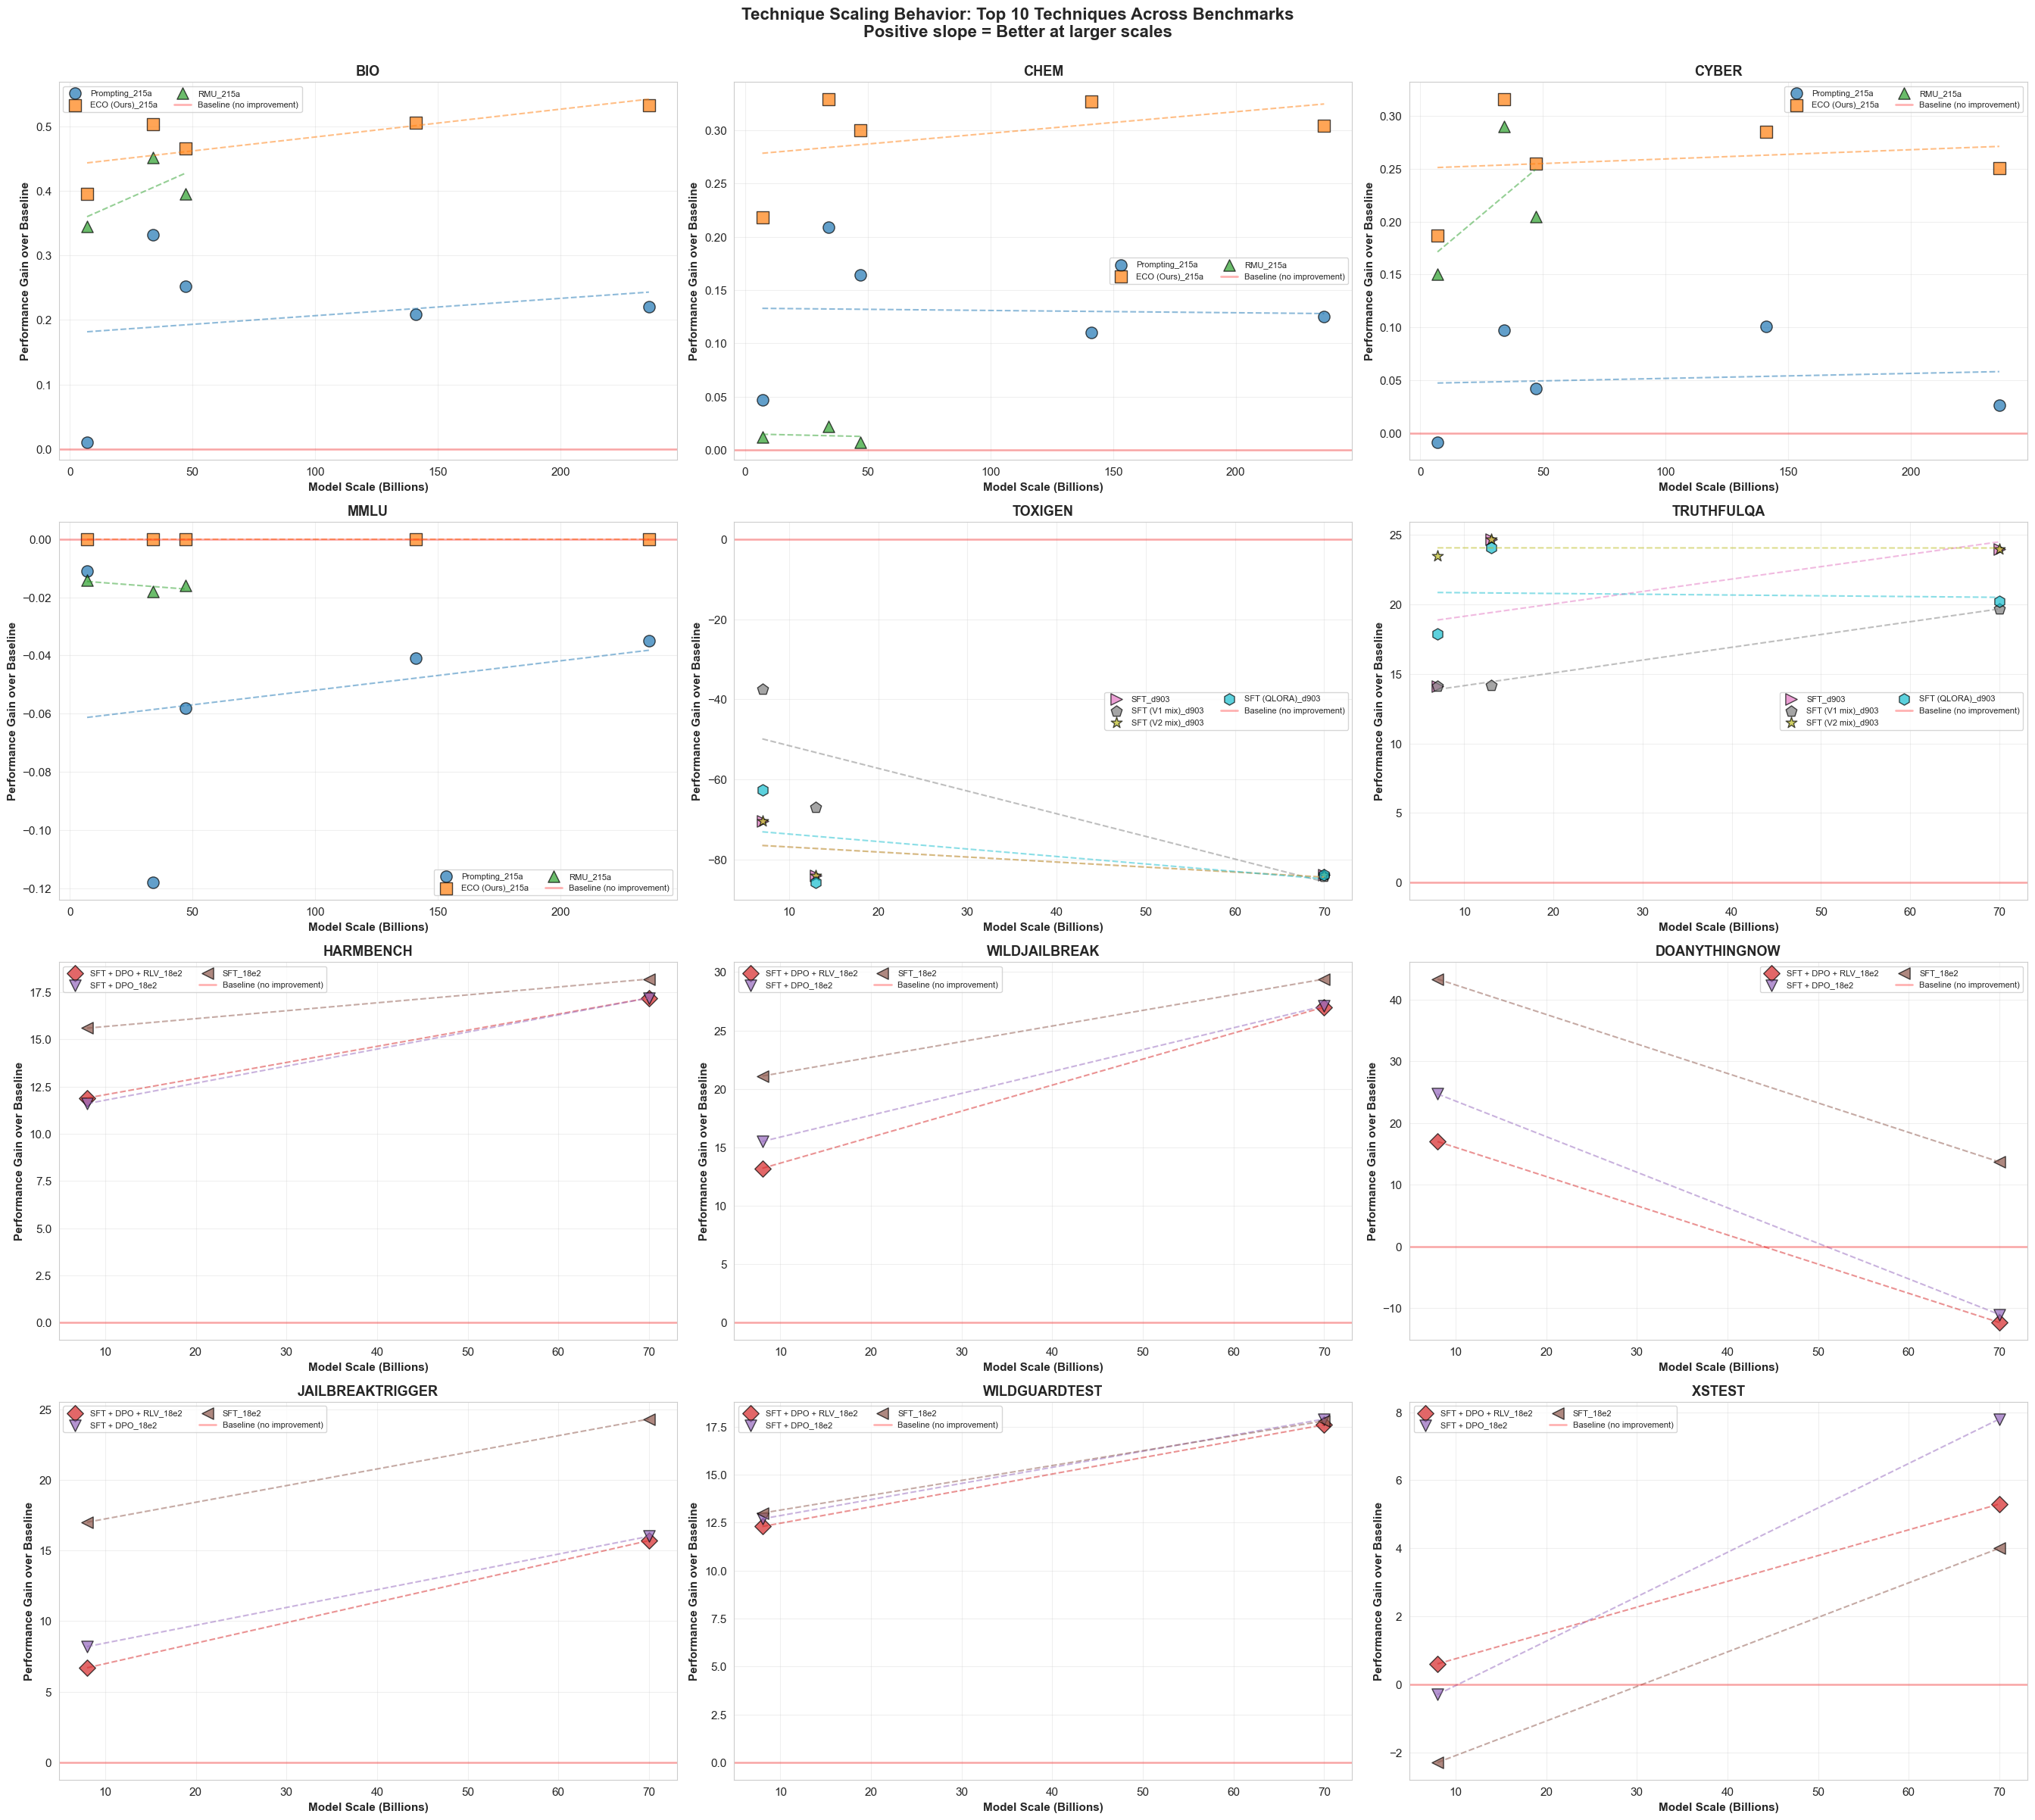


📊 How to read these plots:
  - Points above red line = technique better than baseline
  - Upward trend = technique effectiveness increases with scale
  - Downward trend = technique effectiveness decreases with scale
  - Flat trend = technique effectiveness stable across scales


In [22]:
# Scatter plots showing gain vs scale for each benchmark
# Show top 10 techniques by data point count
top_technique_ids = diff_df['technique_id'].value_counts().head(10).index
diff_plot = diff_df[diff_df['technique_id'].isin(top_technique_ids)]

benchmarks = diff_plot['Benchmark'].unique()
n_benchmarks = len(benchmarks)
n_cols = min(3, n_benchmarks)
n_rows = (n_benchmarks + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(9*n_cols, 6*n_rows))
if n_benchmarks == 1:
    axes = [axes]
else:
    axes = axes.flatten() if n_benchmarks > 1 else [axes]

# Color map for techniques
colors_map = {tid: plt.cm.tab10(i % 10) for i, tid in enumerate(top_technique_ids)}
markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', 'h']

for idx, benchmark in enumerate(benchmarks):
    if idx >= len(axes):
        break
    
    ax = axes[idx]
    
    # Plot each technique
    for tech_idx, technique_id in enumerate(top_technique_ids):
        subset = diff_plot[
            (diff_plot['technique_id'] == technique_id) &
            (diff_plot['Benchmark'] == benchmark)
        ]
        
        if len(subset) > 0:
            tech_name = subset['Technique'].iloc[0]
            ax.scatter(subset['scale_numeric'], subset['Diff_from_baseline'],
                      s=120, alpha=0.7, color=colors_map[technique_id],
                      marker=markers[tech_idx % len(markers)],
                      label=f"{tech_name[:15]}_{subset['paper_id'].iloc[0][:4]}",
                      edgecolors='black', linewidth=1)
            
            # Add trend line if multiple points
            if len(subset) >= 2:
                scales = subset['scale_numeric'].values.reshape(-1, 1)
                diffs = subset['Diff_from_baseline'].values
                model = LinearRegression()
                model.fit(scales, diffs)
                
                scale_range = np.linspace(scales.min(), scales.max(), 50)
                pred = model.predict(scale_range.reshape(-1, 1))
                ax.plot(scale_range, pred, '--', color=colors_map[technique_id],
                       linewidth=1.5, alpha=0.5)
    
    # Zero reference line
    ax.axhline(y=0, color='red', linestyle='-', linewidth=2, alpha=0.3,
              label='Baseline (no improvement)')
    
    ax.set_xlabel('Model Scale (Billions)', fontsize=11, fontweight='bold')
    ax.set_ylabel('Performance Gain over Baseline', fontsize=11, fontweight='bold')
    ax.set_title(f'{benchmark}', fontsize=13, fontweight='bold')
    ax.legend(loc='best', fontsize=8, ncol=2)
    ax.grid(True, alpha=0.3)

# Remove extra subplots
for idx in range(n_benchmarks, len(axes)):
    fig.delaxes(axes[idx])

plt.suptitle(f'Technique Scaling Behavior: Top 10 Techniques Across Benchmarks\nPositive slope = Better at larger scales',
            fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print('\n📊 How to read these plots:')
print('  - Points above red line = technique better than baseline')
print('  - Upward trend = technique effectiveness increases with scale')
print('  - Downward trend = technique effectiveness decreases with scale')
print('  - Flat trend = technique effectiveness stable across scales')

## 4.2 Technique Categorization: Which Techniques Are Best?

**This plot answers**: Which techniques give high performance gains AND scale well?

**How to read**:
- **X-axis (Slope)**: How gain changes with scale (positive = better at larger models)
- **Y-axis (Mean Gain)**: Average performance improvement over baseline
- **Size**: Number of data points (bigger = more evidence)

**What you want**: Top-right quadrant (high gain + scales well)

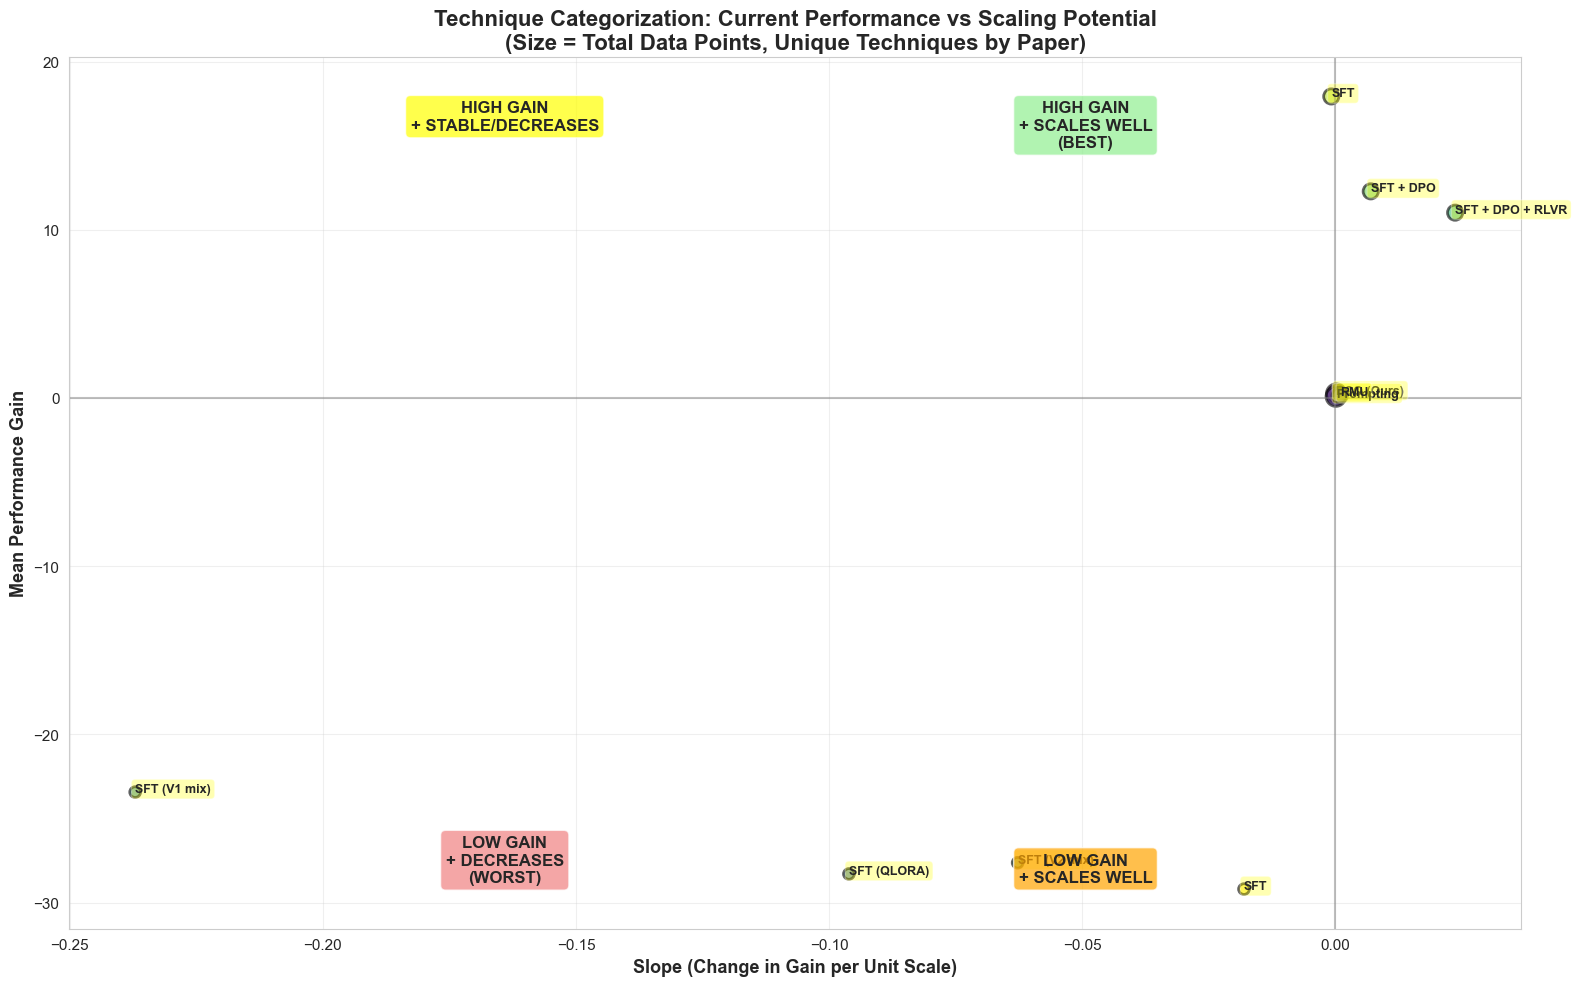


📊 Total unique techniques analyzed: 10


In [19]:
# Scatter plot: Slope vs Mean Gain
# UPDATED: Group by technique_id for unique techniques
tech_summary = tech_scaling_df.groupby('technique_id').agg({
    'Technique': 'first',
    'Slope': 'mean',
    'Mean_gain': 'mean',
    'N_points': 'sum'
}).reset_index()

tech_summary_filtered = tech_summary[tech_summary['N_points'] >= 5]

fig, ax = plt.subplots(figsize=(16, 10))

scatter = ax.scatter(tech_summary_filtered['Slope'], 
                    tech_summary_filtered['Mean_gain'],
                    s=tech_summary_filtered['N_points'] * 10,
                    alpha=0.6, c=range(len(tech_summary_filtered)),
                    cmap='viridis', edgecolors='black', linewidth=2)

# Add labels
for _, row in tech_summary_filtered.iterrows():
    label = row['Technique'][:20] if len(row['Technique']) > 20 else row['Technique']
    ax.annotate(label, 
               (row['Slope'], row['Mean_gain']),
               fontsize=9, fontweight='bold',
               bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.3))

# Add quadrant lines
ax.axhline(y=0, color='gray', linestyle='-', linewidth=1.5, alpha=0.5)
ax.axvline(x=0, color='gray', linestyle='-', linewidth=1.5, alpha=0.5)

# Add quadrant labels
ax.text(0.7, 0.95, 'HIGH GAIN\n+ SCALES WELL\n(BEST)', 
       transform=ax.transAxes, fontsize=12, fontweight='bold',
       bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7),
       ha='center', va='top')
ax.text(0.3, 0.95, 'HIGH GAIN\n+ STABLE/DECREASES', 
       transform=ax.transAxes, fontsize=12, fontweight='bold',
       bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7),
       ha='center', va='top')
ax.text(0.7, 0.05, 'LOW GAIN\n+ SCALES WELL', 
       transform=ax.transAxes, fontsize=12, fontweight='bold',
       bbox=dict(boxstyle='round', facecolor='orange', alpha=0.7),
       ha='center', va='bottom')
ax.text(0.3, 0.05, 'LOW GAIN\n+ DECREASES\n(WORST)', 
       transform=ax.transAxes, fontsize=12, fontweight='bold',
       bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.7),
       ha='center', va='bottom')

ax.set_xlabel('Slope (Change in Gain per Unit Scale)', fontsize=13, fontweight='bold')
ax.set_ylabel('Mean Performance Gain', fontsize=13, fontweight='bold')
ax.set_title('Technique Categorization: Current Performance vs Scaling Potential\n(Size = Total Data Points, Unique Techniques by Paper)',
            fontsize=16, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f'\n📊 Total unique techniques analyzed: {len(tech_summary_filtered)}')